# Setup

In [2]:
# The examples in this notebook use a set of nine benchmarks described in our publication.
# These benchmarks can be downloaded via FTP from: ftp.cs.huji.ac.il/users/nadavb/protein_bert/protein_benchmarks
# Download the benchmarks into a directory on your machine and set the following variable to the path of that directory.
BENCHMARKS_DIR = 'protein_benchmarks'

# Fine-tune the model for the signal peptide benchmark

In [430]:
BENCHMARKS_DIR = 'protein_benchmarks'

import os

import pandas as pd
from IPython.display import display

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator,finetune, evaluate_by_len
from proteinbert.existing_model_loading import load_pretrained_model
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARK_NAME = 'fold_0_0.9'

# A local (non-global) bianry output
OUTPUT_TYPE = OutputType(False, 'categorical')
UNIQUE_LABELS = {
    'antibiotic target alteration':0 ,
    'antibiotic target replacement':1,
    'antibiotic target protection':2,
    'antibiotic inactivation':3,
    'antibiotic efflux':4,
    'others':5
}#[0, 1, 2, 3, 4, 5]

OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)
tf.random.set_seed(1)

# Loading the dataset

train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % BENCHMARK_NAME)
train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
train_set, valid_set = train_test_split(train_set, test_size = 0.1, random_state = 1)

test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % BENCHMARK_NAME)
test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

print(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')


# Loading the pre-trained model and fine-tuning it on the loaded dataset

pretrained_model_generator, input_encoder = load_pretrained_model()

# get_model_with_hidden_layers_as_outputs gives the model output access to the hidden layers (on top of the output)
model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
        get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)

training_callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
    keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

finetune(model_generator, input_encoder, OUTPUT_SPEC, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
        seq_len = 512, batch_size = 32, max_epochs_per_stage = 40, lr = 1e-04, begin_with_frozen_pretrained_layers = True, \
        lr_with_frozen_pretrained_layers = 1e-02, n_final_epochs = 1, final_seq_len = 1024, final_lr = 1e-05, callbacks = training_callbacks)


# Evaluating the performance on the test-set

results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_set['seq'], test_set['label'], \
        start_seq_len = 512, start_batch_size = 32)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)


6435 training set records, 715 validation set records, 1788 test set records.
[2022_11_17-10:55:07] Training set: Filtered out 534 of 6435 (8.3%) records of lengths exceeding 510.
[2022_11_17-10:55:07] Validation set: Filtered out 74 of 715 (10.3%) records of lengths exceeding 510.
[2022_11_17-10:55:08] Training with frozen pretrained layers...
Epoch 1/40
185/185 [==============================] - 70s 344ms/step - loss: 0.1829 - val_loss: 0.1136 - lr: 0.0100
Epoch 2/40
185/185 [==============================] - ETA: 0s - loss: 0.1029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
185/185 [==============================] - 61s 332ms/step - loss: 0.1029 - val_loss: 0.1254 - lr

3/3 [==============================] - 2s 203ms/step
Test-set performance:


,# records,Accuracy
Model seq len,,
512,1750,0.938857
1024,38,0.684211
All,1788,0.933445


Confusion matrix:


,antibiotic target alteration,antibiotic target replacement,antibiotic target protection,antibiotic inactivation,antibiotic efflux,others
antibiotic target alteration,649,35,2,21,3,0
antibiotic target replacement,4,232,0,0,0,0
antibiotic target protection,6,0,3,2,6,0
antibiotic inactivation,14,3,3,521,18,0
antibiotic efflux,0,0,1,1,261,0
others,0,0,0,0,0,3


In [428]:
BENCHMARKS_DIR = 'protein_benchmarks'

import os

import pandas as pd
from IPython.display import display

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator,finetune, evaluate_by_len
from proteinbert.existing_model_loading import load_pretrained_model
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARK_NAME = 'fold_0_0.9'

# A local (non-global) bianry output
OUTPUT_TYPE = OutputType(False, 'categorical')
UNIQUE_LABELS = {
    'antibiotic target alteration':0 ,
    'antibiotic target replacement':1,
    'antibiotic target protection':2,
    'antibiotic inactivation':3,
    'antibiotic efflux':4,
    'others':5
}#[0, 1, 2, 3, 4, 5]

OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)
tf.random.set_seed(42)

# Loading the dataset

train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % BENCHMARK_NAME)
train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
train_set, valid_set = train_test_split(train_set, test_size = 0.1, random_state = 1)

test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % BENCHMARK_NAME)
test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

print(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')


# Loading the pre-trained model and fine-tuning it on the loaded dataset

pretrained_model_generator, input_encoder = load_pretrained_model()

# get_model_with_hidden_layers_as_outputs gives the model output access to the hidden layers (on top of the output)
model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
        get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)

training_callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
    keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

finetune(model_generator, input_encoder, OUTPUT_SPEC, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
        seq_len = 512, batch_size = 32, max_epochs_per_stage = 40, lr = 1e-04, begin_with_frozen_pretrained_layers = True, \
        lr_with_frozen_pretrained_layers = 1e-02, n_final_epochs = 1, final_seq_len = 1024, final_lr = 1e-05, callbacks = training_callbacks)


# Evaluating the performance on the test-set

results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_set['seq'], test_set['label'], \
        start_seq_len = 512, start_batch_size = 32)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)


6435 training set records, 715 validation set records, 1788 test set records.
[2022_11_16-11:30:11] Training set: Filtered out 534 of 6435 (8.3%) records of lengths exceeding 510.
[2022_11_16-11:30:12] Validation set: Filtered out 74 of 715 (10.3%) records of lengths exceeding 510.
[2022_11_16-11:30:12] Training with frozen pretrained layers...
Epoch 1/40
185/185 [==============================] - 73s 352ms/step - loss: 0.1950 - val_loss: 0.1328 - lr: 0.0100
Epoch 2/40
185/185 [==============================] - 63s 343ms/step - loss: 0.1130 - val_loss: 0.1315 - lr: 0.0100
Epoch 3/40
185/185 [==============================] - 126s 683ms/step - loss: 0.0927 - val_loss: 0.1072 - lr: 0.0100
Epoch 4/40
185/185 [==============================] - ETA: 0s - loss: 0.0933WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_m

,# records,Accuracy
Model seq len,,
512,1750,0.947429
1024,38,0.684211
All,1788,0.941834


Confusion matrix:


,antibiotic target alteration,antibiotic target replacement,antibiotic target protection,antibiotic inactivation,antibiotic efflux,others
antibiotic target alteration,655,31,0,20,4,0
antibiotic target replacement,2,234,0,0,0,0
antibiotic target protection,5,0,3,2,7,0
antibiotic inactivation,10,2,1,528,18,0
antibiotic efflux,0,0,1,1,261,0
others,0,0,0,0,0,3


In [423]:
confusion_matrix.to_csv('confusion_matrix_0.9.tsv', sep='\t') #エポック12

# Run all benchmarks

In [ ]:
import os

import pandas as pd
from IPython.display import display

from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len, log
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARKS = [
    # name, output_type
    ('signalP_binary', OutputType(False, 'binary')),
    ('fluorescence', OutputType(False, 'numeric')),
    ('remote_homology', OutputType(False, 'categorical')),
    ('stability', OutputType(False, 'numeric')),
    ('scop', OutputType(False, 'categorical')),
    ('secondary_structure', OutputType(True, 'categorical')),
    ('disorder_secondary_structure', OutputType(True, 'binary')),
    ('ProFET_NP_SP_Cleaved', OutputType(False, 'binary')),
    ('PhosphositePTM', OutputType(True, 'binary')),
]

settings = {
    'max_dataset_size': None,
    'max_epochs_per_stage': 40,
    'seq_len': 512,
    'batch_size': 32,
    'final_epoch_seq_len': 1024,
    'initial_lr_with_frozen_pretrained_layers': 1e-02,
    'initial_lr_with_all_layers': 1e-04,
    'final_epoch_lr': 1e-05,
    'dropout_rate': 0.5,
    'training_callbacks': [
        keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
        keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
    ],
}

####### Uncomment for debug mode
# settings['max_dataset_size'] = 500
# settings['max_epochs_per_stage'] = 1

def run_benchmark(benchmark_name, pretraining_model_generator, input_encoder, pretraining_model_manipulation_function = None):
    
    log('========== %s ==========' % benchmark_name)  
    
    output_type = get_benchmark_output_type(benchmark_name)
    log('Output type: %s' % output_type)
    
    train_set, valid_set, test_set = load_benchmark_dataset(benchmark_name)        
    log(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')
    
    if settings['max_dataset_size'] is not None:
        log('Limiting the training, validation and test sets to %d records each.' % settings['max_dataset_size'])
        train_set = train_set.sample(min(settings['max_dataset_size'], len(train_set)), random_state = 0)
        valid_set = valid_set.sample(min(settings['max_dataset_size'], len(valid_set)), random_state = 0)
        test_set = test_set.sample(min(settings['max_dataset_size'], len(test_set)), random_state = 0)
    
    if output_type.is_seq or output_type.is_categorical:
        train_set['label'] = train_set['label'].astype(str)
        valid_set['label'] = valid_set['label'].astype(str)
        test_set['label'] = test_set['label'].astype(str)
    else:
        train_set['label'] = train_set['label'].astype(float)
        valid_set['label'] = valid_set['label'].astype(float)
        test_set['label'] = test_set['label'].astype(float)
        
    if output_type.is_categorical:
        
        if output_type.is_seq:
            unique_labels = sorted(set.union(*train_set['label'].apply(set)) | set.union(*valid_set['label'].apply(set)) | \
                    set.union(*test_set['label'].apply(set)))
        else:
            unique_labels = sorted(set(train_set['label'].unique()) | set(valid_set['label'].unique()) | set(test_set['label'].unique()))
            
        log('%d unique lebels.' % len(unique_labels))
    elif output_type.is_binary:
        unique_labels = [0, 1]
    else:
        unique_labels = None
        
    output_spec = OutputSpec(output_type, unique_labels)
    model_generator = FinetuningModelGenerator(pretraining_model_generator, output_spec, pretraining_model_manipulation_function = \
            pretraining_model_manipulation_function, dropout_rate = settings['dropout_rate'])
    finetune(model_generator, input_encoder, output_spec, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
            seq_len = settings['seq_len'], batch_size = settings['batch_size'], max_epochs_per_stage = settings['max_epochs_per_stage'], \
            lr = settings['initial_lr_with_all_layers'], begin_with_frozen_pretrained_layers = True, lr_with_frozen_pretrained_layers = \
            settings['initial_lr_with_frozen_pretrained_layers'], n_final_epochs = 1, final_seq_len = settings['final_epoch_seq_len'], \
            final_lr = settings['final_epoch_lr'], callbacks = settings['training_callbacks'])
    
    for dataset_name, dataset in [('Training-set', train_set), ('Validation-set', valid_set), ('Test-set', test_set)]:
        
        log('*** %s performance: ***' % dataset_name)
        results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, output_spec, dataset['seq'], dataset['label'], \
                start_seq_len = settings['seq_len'], start_batch_size = settings['batch_size'])
    
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(results)
        
        if confusion_matrix is not None:
            with pd.option_context('display.max_rows', 16, 'display.max_columns', 10):
                log('Confusion matrix:')
                display(confusion_matrix)
                
    return model_generator

def load_benchmark_dataset(benchmark_name):
    
    train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % benchmark_name)
    valid_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.valid.csv' % benchmark_name)
    test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % benchmark_name)
    
    train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
    test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()
          
    if os.path.exists(valid_set_file_path):
        valid_set = pd.read_csv(valid_set_file_path).dropna().drop_duplicates()
    else:
        log(f'Validation set {valid_set_file_path} missing. Splitting training set instead.')
        train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)
    
    return train_set, valid_set, test_set

def get_benchmark_output_type(benchmark_name):
    for name, output_type in BENCHMARKS:
        if name == benchmark_name:
            return output_type
        
pretrained_model_generator, input_encoder = load_pretrained_model()

for benchmark_name, _ in BENCHMARKS:
    run_benchmark(benchmark_name, pretrained_model_generator, input_encoder, pretraining_model_manipulation_function = \
            get_model_with_hidden_layers_as_outputs)
        
log('Done.')

# Visualizing the attention layers

You can run this only after you have fine-tuned the model on a benchmark (e.g. signal peptide) and obtained *model_generator*.

MKQYLDLLQHVLDHGILKEDRTGTGTISVFGYQMRFNMDEGFPCLTTKKLHLKSIIYELLWFLQGDTNVKYLQDNSVRI antibiotic target alteration


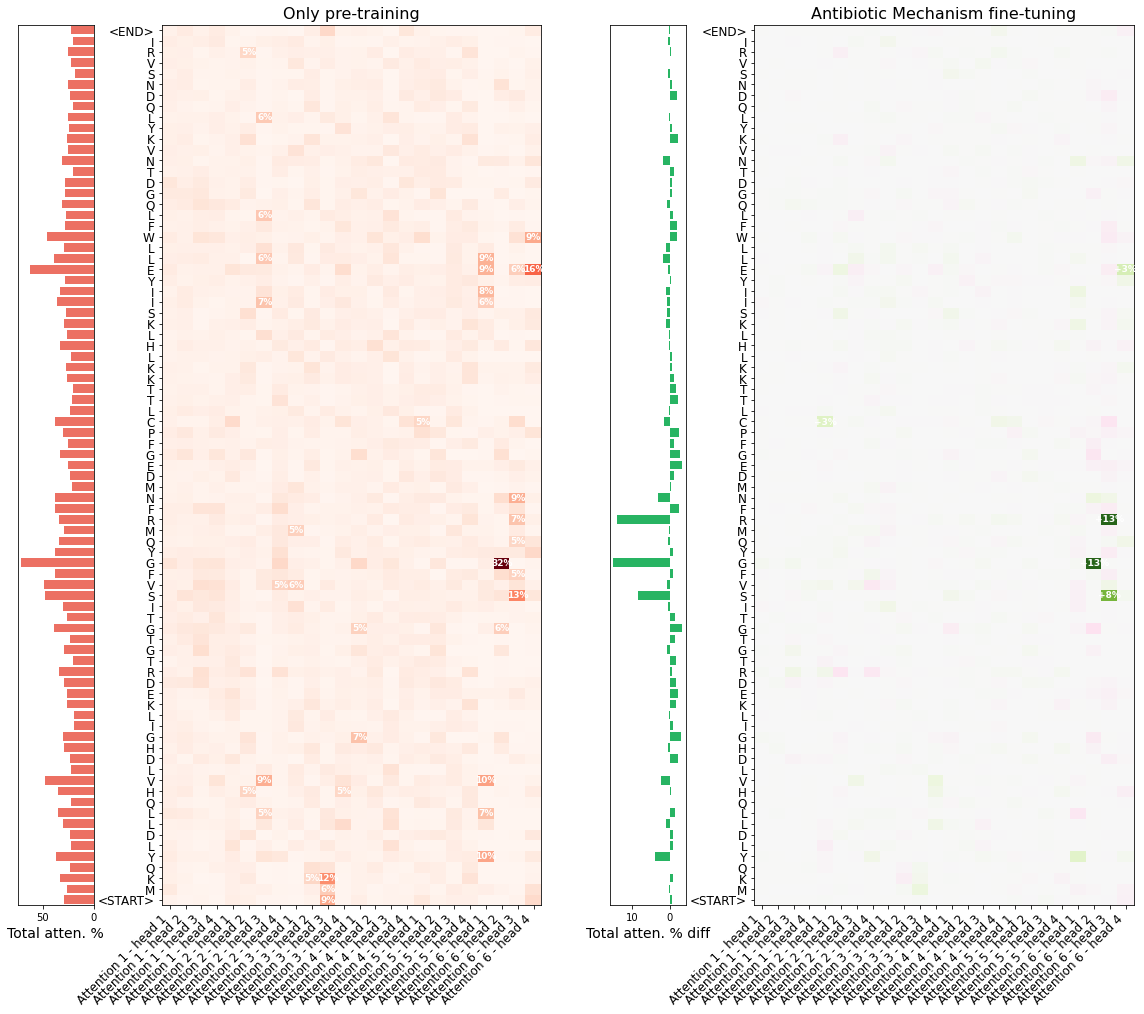

In [443]:
import numpy as np
import matplotlib.pyplot as plt

BENCHMARK_DISPLAY_NAME = 'Antibiotic Mechanism'

TEST_SET_FILE_PATH = 'protein_benchmarks/fold_0_0.9.test.csv'
IDEAL_LEN = 80

def calculate_attentions(model, input_encoder, seq, seq_len = None):
    
    from tensorflow.keras import backend as K
    from proteinbert.tokenization import index_to_token
    
    if seq_len is None:
        seq_len = len(seq) + 2
    
    X = input_encoder.encode_X([seq], seq_len)
    (X_seq,), _ = X
    seq_tokens = list(map(index_to_token.get, X_seq))

    model_inputs = [layer.input for layer in model.layers if 'InputLayer' in str(type(layer))][::-1]
    model_attentions = [layer.calculate_attention(layer.input) for layer in model.layers if 'GlobalAttention' in str(type(layer))]
    invoke_model_attentions = K.function(model_inputs, model_attentions)
    attention_values = invoke_model_attentions(X)
    
    attention_labels = []
    merged_attention_values = []

    for attention_layer_index, attention_layer_values in enumerate(attention_values):
        for head_index, head_values in enumerate(attention_layer_values):
            attention_labels.append('Attention %d - head %d' % (attention_layer_index + 1, head_index + 1))
            merged_attention_values.append(head_values)

    attention_values = np.array(merged_attention_values)
    
    return attention_values, seq_tokens, attention_labels

def plot_attention(attention_values, seq_tokens, attention_labels, ax, cmap = 'Reds', vmin = 0, vmax = None, text_value_threshold = 0.1):

    heatmap = ax.pcolor(attention_values.transpose(), cmap = cmap, vmin = vmin, vmax = vmax)

    ax.set_xticks(np.arange(len(attention_labels)) + 0.5)
    ax.set_xticklabels(attention_labels, rotation = 45, ha = 'right', fontsize = 12)
    ax.set_yticks(np.arange(len(seq_tokens)) + 0.5)
    ax.set_yticklabels(seq_tokens, fontsize = 12)

    for i, row in enumerate(attention_values):
        for j, value in enumerate(row):
            if abs(value) >= text_value_threshold:
                add_plus_sign = attention_values.min() < 0 and value > 0
                plus_sign = '+' if add_plus_sign else ''
                ax.text(i + 0.5, j + 0.5, plus_sign + '%d%%' % (100 * value), color = 'white', ha = 'center', va = 'center', \
                        fontsize = 9, fontweight = 'bold', fontstretch = 'condensed')
                
test_set = pd.read_csv(TEST_SET_FILE_PATH)
chosen_index = ((test_set['seq'].str.len() - IDEAL_LEN).abs()).sort_values().index[1]
seq = test_set.loc[chosen_index, 'seq']
label = test_set.loc[chosen_index, 'label']
                
seq_len = len(seq) + 2

pretrained_model_generator, input_encoder = load_pretrained_model()
model = pretrained_model_generator.create_model(seq_len)
pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)

model = model_generator.create_model(seq_len)
finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)
assert finetuned_seq_tokens == pretrained_seq_tokens
assert finetuned_attention_labels == pretrained_attention_labels[:len(finetuned_attention_labels)]

fig, axes = plt.subplots(ncols = 4, figsize = (20, 0.2 * seq_len), gridspec_kw = dict(width_ratios = [1, 5, 1, 5]))
fig.subplots_adjust(wspace = 0.3)

axes[0].barh(np.arange(seq_len), 100 * pretrained_attention_values.sum(axis = 0), color = '#EC7063')
axes[0].set_ylim((-0.5, seq_len - 0.5))
axes[0].set_yticks([])
axes[0].invert_xaxis()
axes[0].set_xlabel('Total atten. %', fontsize = 14)

vmax = pretrained_attention_values.max()
plot_attention(pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels, axes[1], cmap = 'Reds', vmax = vmax, \
        text_value_threshold = 0.05)
axes[1].set_title('Only pre-training', fontsize = 16)

axes[2].barh(np.arange(seq_len), 100 * (finetuned_attention_values - pretrained_attention_values).sum(axis = 0), color = '#28B463')
axes[2].set_ylim((-0.5, seq_len - 0.5))
axes[2].set_yticks([])
axes[2].invert_xaxis()
axes[2].set_xlabel('Total atten. % diff', fontsize = 14)

attention_diff = finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]
vmax = np.abs(attention_diff).max()
plot_attention(attention_diff, finetuned_seq_tokens, finetuned_attention_labels, axes[3], cmap = 'PiYG', vmin = -vmax, vmax = vmax, \
        text_value_threshold = 0.03)
axes[3].set_title('%s fine-tuning' % BENCHMARK_DISPLAY_NAME, fontsize = 16)

print(seq, label)

In [202]:
pretrained_model_generator, input_encoder = load_pretrained_model()
attn_token = pd.DataFrame(index=amino_acid)

for dataset in test_set.itertuples():
    seq = dataset.seq
    seq_len = len(seq) + 2
    model = model_generator.create_model(seq_len)
    finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, seq,\
            seq_len = seq_len)
    attn_one_seq = pd.DataFrame(np.mean(finetuned_attention_values,axis=0),index=finetuned_seq_tokens)
    attn_one_seq['token'] = attn_one_seq.index
    attn_one_seq = attn_one_seq.groupby('token').mean().sort_index()
    attn_token = pd.concat([attn_token,attn_one_seq],axis=1)
    
attn_token

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A,0.004216,0.003743,0.004435,0.004598,0.005541,0.004593,0.006018,0.002973,0.003072,0.002712,...,0.005784,0.007441,0.005781,0.005990,0.006156,0.006461,0.008191,0.006523,0.007235,0.006626
B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,0.011030,0.017122,NaN,0.006864,0.006309,0.006489,0.006839,0.005854,0.005738,0.005184,...,0.013969,NaN,NaN,NaN,0.008976,0.005107,NaN,NaN,NaN,NaN
D,0.004604,0.004139,0.005314,0.004712,0.005328,0.004330,0.004914,0.003394,0.003302,0.004000,...,0.006654,0.006984,0.006179,0.006462,0.005320,0.005320,0.008445,0.007183,0.006773,0.006283
E,0.005347,0.003313,0.004854,0.004773,0.004835,0.004756,0.004980,0.003087,0.002896,0.002744,...,0.005040,0.005646,0.005355,0.004895,0.006147,0.004614,0.006305,0.005625,0.004614,0.005856
F,0.005735,0.004152,0.004952,0.006847,0.005537,0.005486,0.006068,0.004119,0.003508,0.003282,...,0.005783,0.006827,0.006563,0.006657,0.006634,0.008311,0.008905,0.007192,0.007771,0.007975
G,0.004831,0.004848,0.008761,0.007477,0.008834,0.007699,0.007921,0.003568,0.003021,0.003449,...,0.008450,0.007743,0.009983,0.006647,0.010671,0.010085,0.012829,0.009511,0.007539,0.009501
H,0.007640,0.005066,0.004864,0.005858,0.004752,0.005011,0.005149,0.008441,0.004758,0.010002,...,0.005091,0.006462,0.008705,0.005579,0.006615,0.004421,0.008072,0.005747,0.006067,0.006289
I,0.005056,0.003104,0.004533,0.004857,0.004951,0.004542,0.004897,0.002973,0.003473,0.003361,...,0.005199,0.005894,0.006279,0.006038,0.007195,0.006020,0.010284,0.005710,0.007487,0.007375
J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [365]:
attn_token = attn_token.set_axis(list(range(1785)), axis='columns')

In [366]:
attn_token

,0,1,2,3,4,5,6,7,8,9,...,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784
A,-0.000005,-0.000016,-0.000140,0.000008,-0.000240,-0.000024,-0.000222,-1.006134e-04,-0.000092,-0.000090,...,-0.000473,-0.000560,-0.000536,-0.000409,-0.000230,-0.000207,-0.000012,-0.000126,0.000307,-0.000564
B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,-0.001122,-0.000257,NaN,0.000303,0.000186,-0.000034,0.000122,-7.418668e-06,-0.000171,0.000227,...,0.001006,NaN,NaN,NaN,0.000800,-0.000036,NaN,NaN,NaN,NaN
D,0.000013,0.000195,0.000028,-0.000095,0.000056,0.000038,0.000071,3.404076e-05,0.000163,0.000139,...,0.000210,-0.000004,-0.000069,0.000040,-0.000099,0.000076,0.000056,-0.000053,0.000009,0.000123
E,0.000069,-0.000035,0.000089,0.000044,-0.000004,-0.000068,0.000047,-1.715997e-06,-0.000018,-0.000106,...,-0.000163,-0.000188,-0.000286,-0.000277,-0.000022,-0.000215,-0.000527,-0.000088,-0.000251,-0.000300
F,0.000030,-0.000083,-0.000231,0.000118,-0.000217,0.000133,-0.000044,-1.091706e-04,-0.000181,0.000025,...,0.000053,0.000133,-0.000140,0.000008,0.000017,0.000491,0.000172,0.000179,0.000250,0.000260
G,0.000122,0.000172,0.000245,0.000163,0.000145,0.000201,0.000180,9.424917e-05,0.000076,0.000023,...,0.000086,0.000433,0.000416,0.000229,0.000462,0.000762,0.000249,0.000114,-0.000080,0.000340
H,-0.000010,0.000143,0.000058,-0.000265,-0.000007,-0.000072,0.000126,1.373488e-04,0.000179,0.000368,...,0.000154,-0.000043,0.000266,-0.000083,0.000262,-0.000105,0.000098,-0.000422,0.000100,-0.000027
I,0.000037,-0.000025,-0.000030,0.000015,-0.000001,0.000019,0.000015,6.301806e-06,0.000057,-0.000044,...,0.000041,0.000154,0.000248,0.000368,0.000281,0.000071,0.000437,0.000100,0.000236,0.000290
J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [432]:
finetuned_attention_values

array([[0.00576097, 0.0231756 , 0.01101165, ..., 0.01011402, 0.01603418,
        0.0079474 ],
       [0.00234606, 0.00468288, 0.00665292, ..., 0.01191961, 0.010974  ,
        0.0190604 ],
       [0.00420492, 0.00304706, 0.00101265, ..., 0.00249614, 0.01375166,
        0.00803169],
       ...,
       [0.00055323, 0.00505269, 0.0002711 , ..., 0.00112654, 0.00110112,
        0.00033251],
       [0.00691599, 0.00175785, 0.00058105, ..., 0.0045648 , 0.00146013,
        0.00371258],
       [0.06581587, 0.05514232, 0.00735917, ..., 0.00153523, 0.00112575,
        0.02093264]], dtype=float32)

In [369]:
attn_token.loc['label',:] = test_set['label']

In [370]:
attn_token

,0,1,2,3,4,5,6,7,8,9,...,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784
A,-0.000005,-0.000016,-0.00014,0.000008,-0.00024,-0.000024,-0.000222,-0.000101,-0.000092,-0.00009,...,-0.000473,-0.00056,-0.000536,-0.000409,-0.00023,-0.000207,-0.000012,-0.000126,0.000307,-0.000564
B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,-0.001122,-0.000257,NaN,0.000303,0.000186,-0.000034,0.000122,-0.000007,-0.000171,0.000227,...,0.001006,NaN,NaN,NaN,0.0008,-0.000036,NaN,NaN,NaN,NaN
D,0.000013,0.000195,0.000028,-0.000095,0.000056,0.000038,0.000071,0.000034,0.000163,0.000139,...,0.00021,-0.000004,-0.000069,0.00004,-0.000099,0.000076,0.000056,-0.000053,0.000009,0.000123
E,0.000069,-0.000035,0.000089,0.000044,-0.000004,-0.000068,0.000047,-0.000002,-0.000018,-0.000106,...,-0.000163,-0.000188,-0.000286,-0.000277,-0.000022,-0.000215,-0.000527,-0.000088,-0.000251,-0.0003
F,0.00003,-0.000083,-0.000231,0.000118,-0.000217,0.000133,-0.000044,-0.000109,-0.000181,0.000025,...,0.000053,0.000133,-0.00014,0.000008,0.000017,0.000491,0.000172,0.000179,0.00025,0.00026
G,0.000122,0.000172,0.000245,0.000163,0.000145,0.000201,0.00018,0.000094,0.000076,0.000023,...,0.000086,0.000433,0.000416,0.000229,0.000462,0.000762,0.000249,0.000114,-0.00008,0.00034
H,-0.00001,0.000143,0.000058,-0.000265,-0.000007,-0.000072,0.000126,0.000137,0.000179,0.000368,...,0.000154,-0.000043,0.000266,-0.000083,0.000262,-0.000105,0.000098,-0.000422,0.0001,-0.000027
I,0.000037,-0.000025,-0.00003,0.000015,-0.000001,0.000019,0.000015,0.000006,0.000057,-0.000044,...,0.000041,0.000154,0.000248,0.000368,0.000281,0.000071,0.000437,0.0001,0.000236,0.00029
J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [371]:
attn_token=attn_token.T

## アミノ酸毎のattentionの値

<AxesSubplot:>

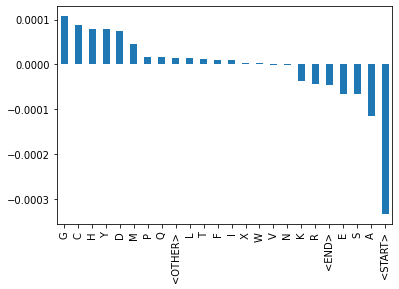

In [367]:
attn_token.mean(axis=1).dropna().sort_values(ascending=False).plot.bar()

In [372]:
def attn_bar(label):
    attn_token[attn_token['label']==label].mean(axis=0).dropna().sort_values(ascending=False).plot.bar(title=label)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


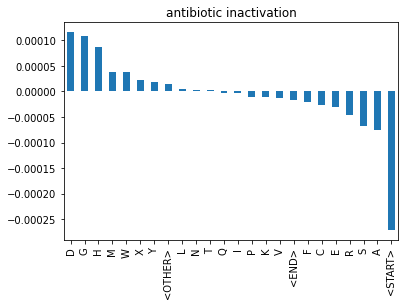

In [373]:
attn_bar('antibiotic inactivation')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


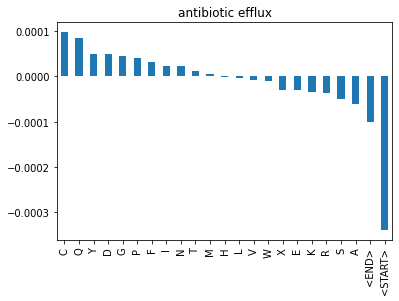

In [374]:
attn_bar('antibiotic efflux')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


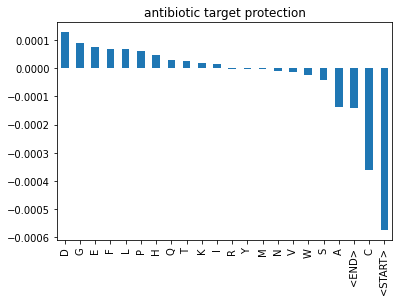

In [375]:
attn_bar('antibiotic target protection')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


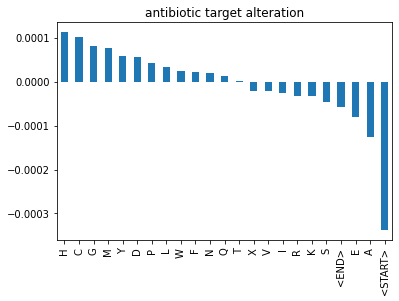

In [376]:
attn_bar('antibiotic target alteration')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


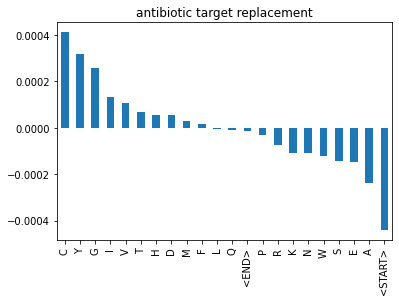

In [377]:
attn_bar('antibiotic target replacement')

In [329]:
attn_diff = finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]

In [337]:
diff_mean[diff_mean<0]

array([-1.33737072e-03, -1.64082550e-04, -3.72180584e-05, -3.12890552e-05,
       -2.15457039e-04, -3.32857715e-04, -1.09898427e-03, -7.65454824e-05,
       -1.10003003e-03, -1.58338895e-04, -4.53950866e-04, -4.82957199e-04,
       -1.30545595e-04, -2.64479982e-04, -3.14173725e-04, -4.03878890e-04,
       -3.02484841e-04, -5.16406028e-04, -8.08056793e-05, -5.60932385e-04,
       -1.48432810e-04, -1.91002720e-04, -3.29660339e-04, -4.52873530e-04,
       -2.67673197e-04, -2.30742153e-04, -4.24875412e-04, -2.26875316e-04,
       -3.32824507e-04, -3.95075098e-04, -3.50249116e-04, -3.24740919e-04,
       -1.79495604e-04, -3.46389315e-05, -1.13244088e-04, -5.04848547e-04,
       -1.49361862e-04, -4.83582611e-04, -4.95263550e-04, -5.71046025e-04,
       -7.90055128e-05, -3.21895030e-04, -1.20258228e-04, -2.15086984e-04,
       -3.69488494e-04, -1.65834663e-05, -2.74454709e-04, -1.64468875e-04,
       -3.37373465e-04, -7.47236118e-05, -6.85340865e-06, -3.80622776e-04,
       -1.80524672e-04, -

In [335]:
diff_mean = np.mean(attn_diff,axis=0)

In [348]:
def diff_attention(sequence):
    seq_len = len(sequence) + 2
    pretrained_model_generator, input_encoder = load_pretrained_model()
    model = pretrained_model_generator.create_model(seq_len)
    pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels = calculate_attentions(model, input_encoder, sequence, \
        seq_len = seq_len)
    model = model_generator.create_model(seq_len)
    finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, sequence,\
            seq_len = seq_len)
    return finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]

In [363]:
pretrained_model_generator, input_encoder = load_pretrained_model()
attn_token = pd.DataFrame(index=amino_acid)

for dataset in test_set.itertuples():
    seq = dataset.seq
    seq_len = len(seq) + 2
    
    model = pretrained_model_generator.create_model(seq_len)
    pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)
    
    model = model_generator.create_model(seq_len)
    finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, seq,\
            seq_len = seq_len)
    attn_diff = finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]
    attn_diff = pd.DataFrame(np.mean(attn_diff,axis=0),index=finetuned_seq_tokens)
    attn_diff['token'] = attn_diff.index
    attn_diff = attn_diff.groupby('token').mean().sort_index()
    attn_token = pd.concat([attn_token,attn_diff],axis=1)
    #print('finish')
attn_token

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A,-0.000005,-0.000016,-0.000140,0.000008,-0.000240,-0.000024,-0.000222,-1.006134e-04,-0.000092,-0.000090,...,-0.000473,-0.000560,-0.000536,-0.000409,-0.000230,-0.000207,-0.000012,-0.000126,0.000307,-0.000564
B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,-0.001122,-0.000257,NaN,0.000303,0.000186,-0.000034,0.000122,-7.418668e-06,-0.000171,0.000227,...,0.001006,NaN,NaN,NaN,0.000800,-0.000036,NaN,NaN,NaN,NaN
D,0.000013,0.000195,0.000028,-0.000095,0.000056,0.000038,0.000071,3.404076e-05,0.000163,0.000139,...,0.000210,-0.000004,-0.000069,0.000040,-0.000099,0.000076,0.000056,-0.000053,0.000009,0.000123
E,0.000069,-0.000035,0.000089,0.000044,-0.000004,-0.000068,0.000047,-1.715997e-06,-0.000018,-0.000106,...,-0.000163,-0.000188,-0.000286,-0.000277,-0.000022,-0.000215,-0.000527,-0.000088,-0.000251,-0.000300
F,0.000030,-0.000083,-0.000231,0.000118,-0.000217,0.000133,-0.000044,-1.091706e-04,-0.000181,0.000025,...,0.000053,0.000133,-0.000140,0.000008,0.000017,0.000491,0.000172,0.000179,0.000250,0.000260
G,0.000122,0.000172,0.000245,0.000163,0.000145,0.000201,0.000180,9.424917e-05,0.000076,0.000023,...,0.000086,0.000433,0.000416,0.000229,0.000462,0.000762,0.000249,0.000114,-0.000080,0.000340
H,-0.000010,0.000143,0.000058,-0.000265,-0.000007,-0.000072,0.000126,1.373488e-04,0.000179,0.000368,...,0.000154,-0.000043,0.000266,-0.000083,0.000262,-0.000105,0.000098,-0.000422,0.000100,-0.000027
I,0.000037,-0.000025,-0.000030,0.000015,-0.000001,0.000019,0.000015,6.301806e-06,0.000057,-0.000044,...,0.000041,0.000154,0.000248,0.000368,0.000281,0.000071,0.000437,0.000100,0.000236,0.000290
J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [440]:
attn = pd.DataFrame(finetuned_attention_values,columns=finetuned_seq_tokens,index=finetuned_attention_labels)

In [442]:
attn.to_csv('attention.csv')